In [1]:
pip install nibabel matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import os
import zipfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **Step 1: Load Data**

In [ ]:
# Define paths
data_path = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
zip_file = os.path.join(data_path, 'HNTSMRG24_train.zip')

# Path to save extracted files
extracted_path = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the dataset into the specified directory
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract only the 'preRT/' files
    preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
    zip_ref.extractall(path=extracted_path, members=preRT_files)

In [ ]:
# Path to the training data
train_dir = os.path.join(extracted_path, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(train_dir)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


# **Step 2: Exploratory Data Analysis (EDA)**

**Prepare EDA**

In [ ]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders[:10]:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))


**EDA: Image Dimensions**

In [ ]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.0,512.0,70.0
1,Maximum,640.0,640.0,110.0
2,Mean (rounded),526.4,526.4,77.2


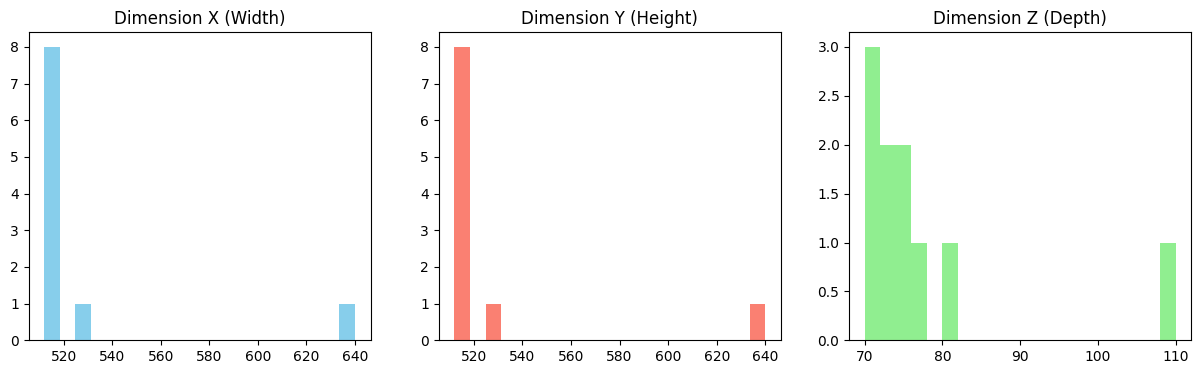

In [ ]:
# Plot histograms of dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(dimensions_array[:, 0], bins=20, color='skyblue')
axes[0].set_title('Dimension X (Width)')
axes[1].hist(dimensions_array[:, 1], bins=20, color='salmon')
axes[1].set_title('Dimension Y (Height)')
axes[2].hist(dimensions_array[:, 2], bins=20, color='lightgreen')
axes[2].set_title('Dimension Z (Depth)')
plt.show()

**EDA: Tumor Size and Location**

In [ ]:
# TODO

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [ ]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

print("Class Distribution in Masks (% of total voxels):")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.4f}%")

Class Distribution in Masks (% of total voxels):
Class 0: 99.6534%
Class 1: 0.1158%
Class 2: 0.2308%


**Plot samples**

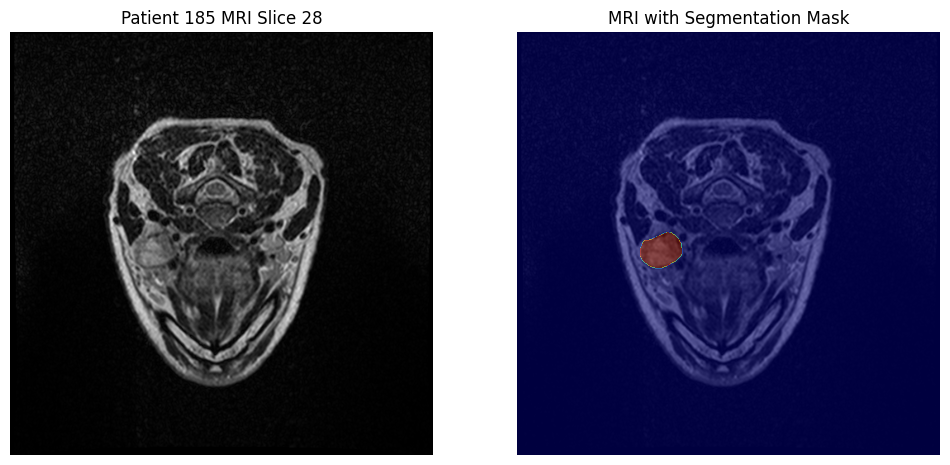

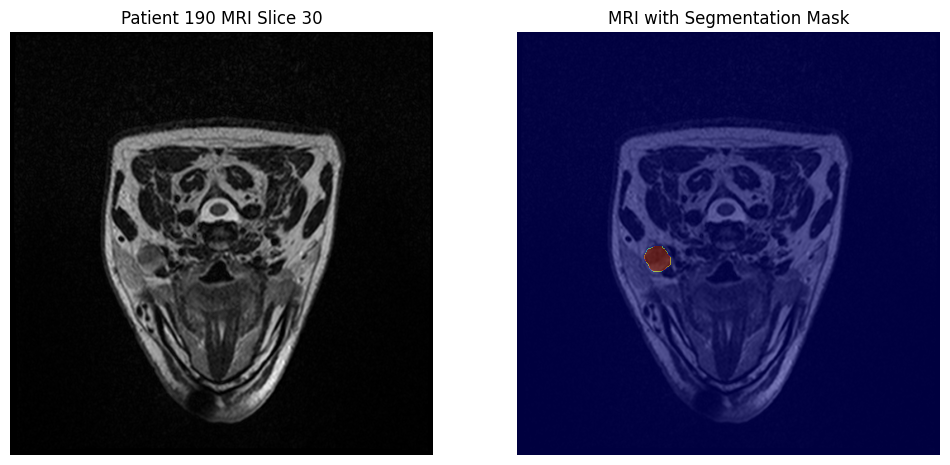

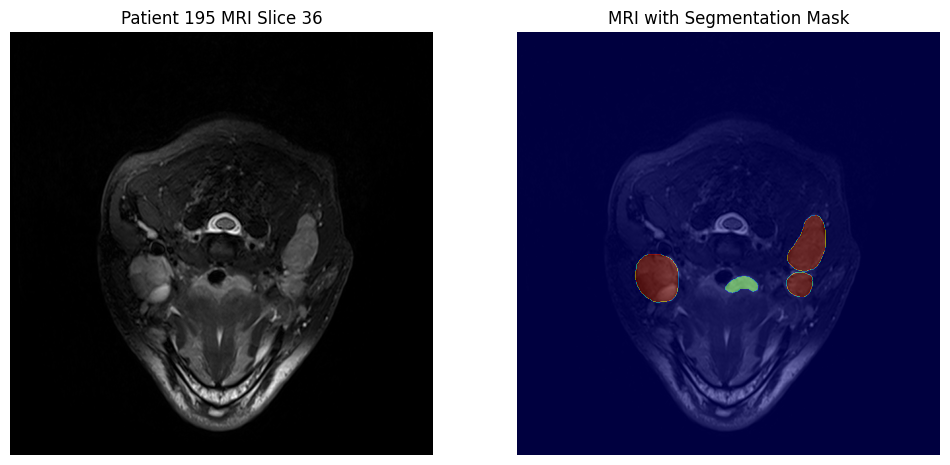

In [ ]:
def plot_sample(patient_id, slice_index=None):
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Use the middle slice
    slice_index = mri_data.shape[2] // 2
    
    mri_slice = mri_data[:, :, slice_index]
    mask_slice = mask_data[:, :, slice_index]
    
    # Plot MRI and Mask
    plt.figure(figsize=(12, 6))
    
    # MRI Image
    plt.subplot(1, 2, 1)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.title(f'Patient {patient_id} MRI Slice {slice_index}')
    plt.axis('off')
    
    # Mask Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('MRI with Segmentation Mask')
    plt.axis('off')
    
    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for patient_id in patient_ids:
    plot_sample(patient_id)

# **Step 3: Data Preprocessing**

In [ ]:
import torch
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    EnsureTyped, Resized
)
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

In [ ]:
# Create data dictionaries
data_dicts = [
    {
        "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
        "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
    }
    for pid in patient_folders
]

**Split the dataset into training and validation**

In [ ]:
# Split data into training and validation sets
train_files = data_dicts[:120]  # First 130 patients for training
val_files = data_dicts[120:]    # Remaining for validation

**Transform image**

In [ ]:
# Define the desired spatial size (should be divisible by 16)
desired_shape = (512, 512, 64)
# Update the transforms to include resizing
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),           # Load images and labels
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure channel dimension
    ScaleIntensityd(keys=["image"]),               # Scale image intensity to [0, 1]
    Resized(keys=["image", "label"], spatial_size=desired_shape, mode=("trilinear", "nearest")), # Ensure equal size
    EnsureTyped(keys=["image", "label"]),          # Convert to PyTorch tensors
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "label"], spatial_size=desired_shape, mode=("trilinear", "nearest")), # Ensure equal size
    EnsureTyped(keys=["image", "label"]),
])

**Create dataset and dataloaders**

In [ ]:
# Create datasets
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


# **Step 4: Build Model**

Define Model, Loss, Optimizer, and Metrics

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model (3D UNet)
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,  # Number of classes (background + 2 classes)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Use DiceCELoss to handle class imbalance
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# **Step 5: Train and Validate Model**

In [ ]:
# Training Loop
max_epochs = 10
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        # Get inputs and labels
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_function(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Training loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:

            # Get inputs and labels
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels)

            # Accumulate loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

Epoch 1/10
Training loss: 0.9613
Validation Loss: 0.7026
Epoch 2/10


# **Step 6: Evaluate Model**

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os

def plot_prediction(model, patient_id, slice_index=None, device='cpu'):
    # Set model to evaluation mode
    model.eval()
    
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Use the middle slice
    slice_index = mri_data.shape[2] // 2
    
    # Preprocess the MRI data similarly to training
    with torch.no_grad():
        # Prepare the input tensor
        input_dict = {
            "image": mri_path,
            "label": mask_path
        }
        processed = val_transforms(input_dict)
        input_tensor = processed["image"].unsqueeze(0).to(device)  # Add batch dimension
        
        # Run the model
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the relevant slice
    mri_slice = mri_data[:, :, slice_index]
    mask_slice = mask_data[:, :, slice_index]
    predicted_slice = predicted[:, :, slice_index]
    
    # Plot MRI, Ground Truth, and Prediction
    plt.figure(figsize=(18, 6))
    
    # MRI Image
    plt.subplot(1, 3, 1)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.title(f'Patient {patient_id} MRI Slice {slice_index}')
    plt.axis('off')
    
    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(predicted_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for patient_id in patient_ids:
    plot_prediction(model, patient_id=patient_id, device=device)


RuntimeError: The size of tensor a (64) must match the size of tensor b (512) at non-singleton dimension 2